<hr style="border:2px solid gray"> </hr>

#  Traveling Salesman Problem

## Example Code

### Algorithm 4: Genetic Algorithm

<hr style="border:2px solid gray"> </hr>

In [1]:
# package list
import numpy as np
import sys

import matplotlib.pyplot as plt
import time
import random
import functools

# Global Variables
# GA
POOL_SIZE = 20
TOURNAMENT_SIZE = 4
MAX_ITERATION = 20000
TIME_LIMIT = 57
# Plot Settings
PLOT_MODE = True # Draw Route
plt.ion()


In [2]:
#important! 여기는 수정 금지
def timing(func):
    """함수 실행 시간을 측정하는 데코레이터"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{func.__name__} 실행 시간: {end - start:.6f} 초")
        return result
    return wrapper

SEED = 42
np.random.seed(SEED)   # numpy 전역 시드
random.seed(SEED)      # 파이썬 내장 random 시드

In [3]:
file_path = 'data1.txt'

# Step 1. Data Loading

In [4]:
def fileloader():
    #     Data Format
    #     ---------------------------------------------------------
    #     NAME : pia3056
    #     COMMENT : Bonn VLSI data set with 3056 points
    #     COMMENT : Uni Bonn, Research Institute for Discrete Math
    #     COMMENT : Contributed by Andre Rohe
    #     TYPE : TSP
    #     DIMENSION : 3056 -----------------------------|
    #     EDGE_WEIGHT_TYPE : EUC_2D                     |
    #     NODE_COORD_SECTION                            |
    #     1 0 11 (2 dimentional coordinate of city)     |
    #     2 0 115                                       |
    #     ...                                           |
    #     ...(Total 3056 nodes)<------------------------|
    #     EOF
    #     ---------------------------------------------------------
    with open(file_path, "r") as file:
        file_str = file.readlines()

    # Get the coordinates of cities
    coord_str = file_str[8:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = float(items[1]), float(items[2])

    return coord_list

# Step 2. Initialization

In [5]:
def path_cost(path_map, path):

    return path_map[path[:-1], path[1:]].sum()

def initialize_greedy(coord_list, path_map, first_idx):
    n = len(coord_list)
    path = np.zeros(n + 1, dtype=np.int32)
    path[0] = path[-1] = first_idx

    visited = np.ones(n, dtype=bool) # 모두 방문해야 함을 True로 표시
    visited[first_idx] = False # 시작점은 방문한 것으로 처리

    current_city = first_idx
    for i in range(1, n):
        dist = path_map[current_city].copy()
        dist[~visited] = np.inf # 아직 방문하지 않은(True) 도시들 중에서만 선택
        next_city = np.argmin(dist)
        path[i] = next_city
        visited[next_city] = False
        current_city = next_city

    return path

def initialize_random(coord_list, first_idx):
    n = len(coord_list)
    path = np.zeros(n + 1, dtype=np.int32)
    path[0] = path[-1] = first_idx

    rem = np.delete(np.arange(n, dtype=np.int32), first_idx)
    path[1:-1] = np.random.permutation(rem)

    return path

# Step 3. Searching a path

## Algorithm 4. Genetic Algorithm

In [6]:
def initialization(coord_list, path_map, pool_size):
    """초기 해 집단을 생성하고, 그 중 상위 20%만 2-opt 폴리싱으로 빠르게 품질을 개선합니다."""
    n = len(coord_list)
    path_pool = np.zeros((pool_size, n + 1), dtype=np.int32)
    pool_cost = np.zeros(pool_size)

    # 1. 그리디 + 랜덤 초기해 생성
    greedy_count = pool_size // 2
    greedy_starts = np.random.choice(n, greedy_count, replace=False)
    for i in range(greedy_count):
        path_pool[i, :] = initialize_greedy(coord_list, path_map, greedy_starts[i])

    for i in range(greedy_count, pool_size):
        start = np.random.randint(0, n)
        path_pool[i, :] = initialize_random(coord_list, start)

    # 2. 폴리싱 전, 모든 초기해의 비용을 먼저 계산
    for i in range(pool_size):
        pool_cost[i] = path_cost(path_map, path_pool[i])

    # 💡 [핵심 아이디어 1 적용] 비용이 낮은 상위 20%의 인덱스를 찾습니다.
    top_k = int(pool_size * 0.2)
    cost_indices = np.argsort(pool_cost)[:top_k]

    print(f"Polishing top {top_k} initial solutions with 2-opt...")

    # 💡 [핵심 아이디어 2 적용] 상위 20% 해에 대해서만, 반복 횟수를 100으로 제한하여 폴리싱을 수행합니다.
    for i in cost_indices:
        polished_path, polished_cost = limited_2_opt(path_pool[i], path_map, max_attempts=100) # 반복 횟수 제어
        path_pool[i] = polished_path
        pool_cost[i] = polished_cost

    print("Polishing finished.")

    return path_pool, pool_cost

In [7]:
def selection(pool_cost, k):
    """토너먼트 선택."""
    selected_indices = np.random.choice(len(pool_cost), k, replace=False)
    tournament_costs = pool_cost[selected_indices]
    winner_local_idx = np.argmin(tournament_costs)
    return selected_indices[winner_local_idx]

def crossover_ox1(p1, p2):
    """Order Crossover (OX1)."""
    n = len(p1) - 1  # 도시의 수

    # 실제 순열이 담긴 경로의 핵심 부분 (길이: n-1)
    p1_core = p1[1:-1]
    p2_core = p2[1:-1]

    # 자식의 핵심 경로 배열 (길이: n-1)
    child_core = np.full(n - 1, -1, dtype=np.int32)

    # 교차점 두 개를 핵심 경로 길이(n-1) 내에서 선택
    start, end = np.sort(np.random.choice(range(n - 1), 2, replace=False))

    # 부모1의 유전자 일부를 자식에게 복사
    child_core[start:end+1] = p1_core[start:end+1]

    # 부모2에서, 자식에게 아직 없는 유전자를 순서대로 추출
    p2_genes_to_add = [gene for gene in p2_core if gene not in child_core]

    # 자식의 비어있는(-1) 공간을 부모2의 유전자로 채움
    p2_idx = 0
    for i in range(n - 1):
        if child_core[i] == -1:
            child_core[i] = p2_genes_to_add[p2_idx]
            p2_idx += 1

    # 전체 경로 재구성 [시작도시, ...핵심경로..., 시작도시]
    final_child = np.zeros(n + 1, dtype=np.int32)
    final_child[0] = final_child[n] = p1[0] # 부모1의 시작 도시를 유지
    final_child[1:-1] = child_core

    return final_child

def crossover_pmx(p1, p2):

    n = len(p1) - 1
    p1_core, p2_core = p1[1:-1], p2[1:-1]

    child_core = np.full(n - 1, -1, dtype=np.int32)

    # 1. 교차점 선택 및 부모1의 유전자 복사
    start, end = np.sort(np.random.choice(range(n - 1), 2, replace=False))
    child_core[start:end+1] = p1_core[start:end+1]

    # 2. 매핑 정보 생성
    mapping = {p1_core[i]: p2_core[i] for i in range(start, end + 1)}

    # 3. 부모2의 유전자를 자식에게 복사 (중복 처리)
    for i in range(n - 1):
        if start <= i <= end:
            continue

        gene = p2_core[i]
        while gene in child_core:
            gene = mapping.get(gene, gene) # gene이 매핑에 없으면 gene 자신을 사용
            if gene not in mapping: # 순환 참조 방지
                break
        child_core[i] = gene

    # 전체 경로 재구성
    final_child = np.zeros(n + 1, dtype=np.int32)
    final_child[0] = final_child[n] = p1[0]
    final_child[1:-1] = child_core

    return final_child

def mutation_inversion(path):
    """Inversion Mutation."""
    n = len(path) - 1
    # 경로의 핵심 부분(1 ~ n-1) 내에서 두 점 선택
    i, j = np.sort(np.random.choice(range(1, n), 2, replace=False))
    path[i:j+1] = np.flip(path[i:j+1])
    return path

In [8]:
def limited_2_opt(path, path_map, max_attempts=50):
    """제한된 횟수만큼 무작위 2-opt 교환을 시도하는 지역 탐색."""
    n = len(path) - 1
    max_attempts = n
    best_path = path.copy()
    current_best_cost = path_cost(path_map, best_path)
    for _ in range(max_attempts):
        i, j = np.sort(np.random.choice(range(1, n), 2, replace=False))
        p = best_path
        old_dist = path_map[p[i-1], p[i]] + path_map[p[j], p[j+1]]
        new_dist = path_map[p[i-1], p[j]] + path_map[p[i], p[j+1]]
        if new_dist < old_dist:
            best_path[i:j+1] = np.flip(best_path[i:j+1])
            current_best_cost += (new_dist - old_dist)
    return best_path, current_best_cost

In [9]:
@timing
def alg(coord_list): # 함수명 변경
    start_time_main = time.time()
    print('Start Memetic Algorithm (Hybrid GA)')

    # --- 파라미터 설정 ---
    initial_mutation_rate = 0.3
    min_mutation_rate = 0.01
    LOCAL_SEARCH_RATE = 0.1
    CROSSOVER_MIX_RATE = 0.25# OX와 PMX를 섞을 확률

    # --- 초기화 ---
    coord_list = np.array(coord_list)
    diff = coord_list[:, np.newaxis, :] - coord_list[np.newaxis, :, :]
    path_map = np.sqrt((diff**2).sum(axis=-1))

    print('Initialize the population')
    path_pool, pool_cost = initialization(coord_list, path_map, POOL_SIZE)

    best_idx = np.argmin(pool_cost)
    best_path = path_pool[best_idx].copy()
    best_cost = pool_cost[best_idx]

    print(f"Initial best cost: {best_cost:.2f}")

    # --- 시각화 준비 (제출 시 PLOT_MODE = False로 변경) ---
    if PLOT_MODE:
        fig, ax = plt.subplots(figsize=(10, 10))
        plt.ion()

    print('Start the evolution')
    iteration = 0
    while time.time() - start_time_main < TIME_LIMIT:
        iteration += 1

        # 시간에 따른 동적 돌연변이율 계산 (전략 2: 이미 구현됨)
        elapsed_ratio = (time.time() - start_time_main) / TIME_LIMIT
        current_mutation_rate = initial_mutation_rate * (1 - elapsed_ratio) + min_mutation_rate * elapsed_ratio

        # 선택 및 교차
        p1_idx = selection(pool_cost, TOURNAMENT_SIZE)
        p2_idx = selection(pool_cost, TOURNAMENT_SIZE)

        # ▼▼▼ [수정된 부분] 교차 연산자 다양화 (전략 3) ▼▼▼
        if np.random.rand() < CROSSOVER_MIX_RATE:
            child = crossover_ox1(path_pool[p1_idx], path_pool[p2_idx])
        else:
            child = crossover_pmx(path_pool[p1_idx], path_pool[p2_idx])
        # ▲▲▲ [수정된 부분] ▲▲▲

        if np.random.rand() < current_mutation_rate:
            child = mutation_inversion(child)

        child_cost = path_cost(path_map, child)

        # 지역 탐색 (전략 1: 이미 구현됨)
        if np.random.rand() < LOCAL_SEARCH_RATE:
            child, child_cost = limited_2_opt(child, path_map)

        # 세대 교체 (전략 6: 이미 구현됨)
        worst_idx = np.argmax(pool_cost)
        if child_cost < pool_cost[worst_idx]:
            path_pool[worst_idx] = child
            pool_cost[worst_idx] = child_cost

        # --- 최고 기록 갱신 및 시각화 ---
        if child_cost < best_cost:
            best_cost = child_cost
            best_path = child.copy()
            print(f"New best cost at iter {iteration}: {best_cost:.2f}")

            if PLOT_MODE:
                ax.clear()
                ax.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
                ax.set_title(f'City Route: Iteration {iteration} / Cost: {best_cost:.2f}')
                route_xy = coord_list[best_path]
                ax.plot(route_xy[:, 0], route_xy[:, 1], 'k--')
                fig.canvas.draw()
                fig.canvas.flush_events()

    if PLOT_MODE:
        plt.ioff()
        plt.show()

    print(f"Total iterations in {TIME_LIMIT}s: {iteration}")
    return best_path, best_cost

# Main

Problem loaded with 131 cities.
Start Memetic Algorithm (Hybrid GA)
Initialize the population
Polishing top 4 initial solutions with 2-opt...
Polishing finished.
Initial best cost: 649.27
Start the evolution
New best cost at iter 60: 647.10
New best cost at iter 114: 644.90
New best cost at iter 115: 644.90
New best cost at iter 146: 630.20
New best cost at iter 184: 626.31
New best cost at iter 238: 621.74
New best cost at iter 266: 617.93
New best cost at iter 409: 617.30
New best cost at iter 410: 616.02
New best cost at iter 413: 616.02
New best cost at iter 450: 615.77
New best cost at iter 613: 612.41
New best cost at iter 653: 602.02
New best cost at iter 730: 599.50
New best cost at iter 736: 599.50
New best cost at iter 860: 596.24
New best cost at iter 922: 593.53
New best cost at iter 1001: 593.35
New best cost at iter 1007: 593.35
New best cost at iter 1481: 590.37


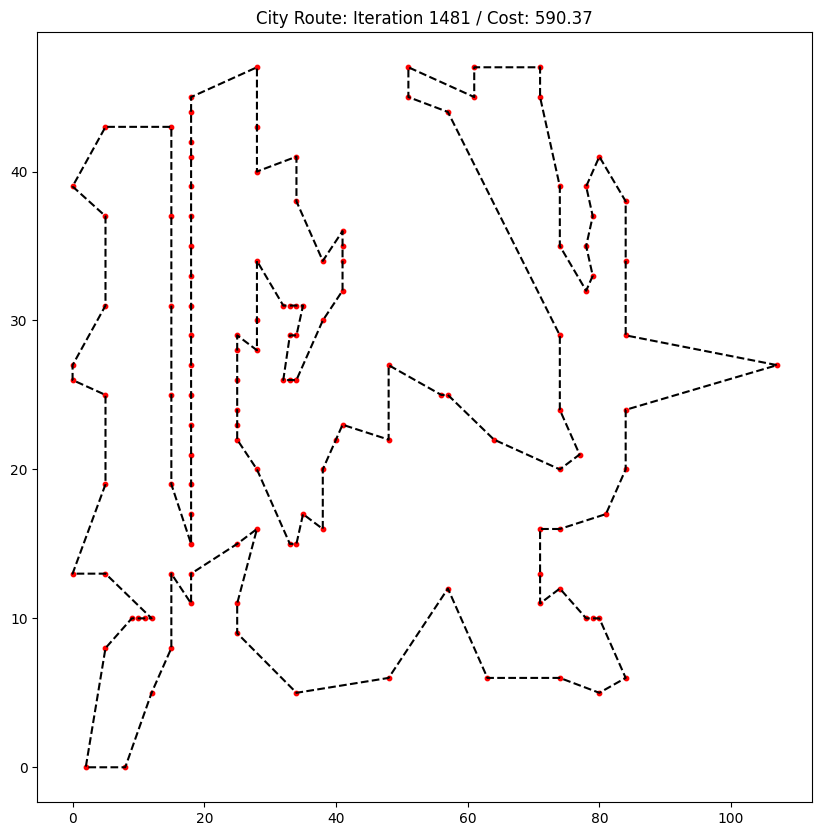

Total iterations in 57s: 42174
alg 실행 시간: 57.209897 초

Total Execution Time: 57.2099 seconds
Path: [105, 101, 100, 99, 104, 113, 117, 120, 129, 122, 111, 97, 92, 88, 73, 52, 44, 53, 45, 26, 25, 18, 24, 17, 12, 4, 11, 13, 14, 15, 16, 5, 0, 6, 7, 1, 2, 8, 9, 3, 10, 23, 22, 21, 20, 19, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 60, 59, 58, 72, 71, 79, 85, 84, 83, 82, 78, 68, 64, 61, 65, 69, 75, 70, 66, 62, 57, 56, 55, 51, 50, 49, 48, 47, 46, 54, 63, 67, 74, 76, 77, 80, 81, 86, 87, 91, 93, 98, 106, 112, 107, 108, 94, 89, 90, 95, 96, 103, 102, 110, 109, 114, 118, 115, 119, 116, 121, 128, 127, 126, 130, 125, 124, 123, 105]
Final Cost: 590.3674461302126


In [10]:
try:

    coord_list = fileloader()

    if coord_list is not None:
        num_cities = len(coord_list)
        print(f"Problem loaded with {num_cities} cities.")

        start_time_total = time.time()
        best_path, best_cost = alg(coord_list)
        end_time_total = time.time()

        print(f"\nTotal Execution Time: {end_time_total - start_time_total:.4f} seconds")
        print(f"Path: {best_path.tolist()}")
        print(f"Final Cost: {best_cost}")

except Exception as e:
    print(f'최종 실행 중 예외 발생: {e}')
